In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Tesi')

In [ ]:
import cv2
import math
import copy
import random
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import load_model
from tensorflow.keras.utils import Sequence

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sequence_length = 4
sequence_stride = 2
batch_size      = 16

# Network model

## Loading the pre-trained model

In [ ]:
ed_path = 'models/urban/ED_urban_pre-trained.h5'
ed = load_model(ed_path)

ed.summary()

## Remove the last layers

In [ ]:
from keras import Model

ed_nofreeze = Model(inputs=ed.input, outputs=ed.layers[-4].output)

for layer in ed_nofreeze.layers:
  layer.trainable = True

# ed_nofreeze.summary()

## CNN + LSTM

In [ ]:
from keras.layers import TimeDistributed, Input, LSTM, Dense, Dropout

input_layer = Input(shape=(sequence_length, 224, 224, 3))
mnv2_reshaped = TimeDistributed(mnv2_nofreeze)(input_layer)
CNNandLSTM = LSTM(100, activation='relu')(mnv2_reshaped)
dropout = Dropout(0.5)(CNNandLSTM)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=input_layer, outputs=output)
model.summary()

In [ ]:
model.save('models/urban/ED_LSTM_urban_trainable_True.h5')

# Inference with pre-trained CNN on single test frames

In [ ]:
path = 'csv/Test/urban/KFold_short-range/fold5'
csvs = os.listdir(path)
test_data = {'filename':[], 'Flames':[]}

for csv in csvs:
    temp = pd.read_csv(path + '/' + csv)
    for index, row in temp.iterrows():
      test_data['filename'].append(row['filename'])
      test_data['Flames'].append(row['Flames'])

test_data = pd.DataFrame(test_data)
print("Test data samples: " + str(len(test_data)) + ".\nPositive test frames: " +
      str(test_data[test_data['Flames'] == 1].count()[0]) + ".\nNegative test frames: " +
      str(test_data[test_data['Flames'] == 0].count()[0]) + ".")

Test data samples: 2134.
Positive test frames: 1083.
Negative test frames: 1051.


In [ ]:
# putting our test data labels in the proper format and shape desired
col = test_data['Flames']
col = list(col)

t = []
for i in col:
  t.append(str(i))

td = {'filename':[], 'Flames':[]}

for index, row in test_data.iterrows():
  td['filename'].append(row['filename'])
  td['Flames'].append(t[index])

test_data = pd.DataFrame(td)

In [ ]:
new_test_data = {'filename':[], 'Flames':[]}

for index, row in test_data.iterrows():
  new_test_data['filename'].append('/content/drive/My Drive' + row['filename'][30:])
  new_test_data['Flames'].append(str(row['Flames']))

n_t_d = pd.DataFrame(new_test_data)

In [ ]:
import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping

test_datagen = ImageDataGenerator(preprocessing_function = tensorflow.keras.applications.efficientnet.preprocess_input)

test_generator = test_datagen.flow_from_dataframe(dataframe = n_t_d, 
                                                    x_col='filename', 
                                                    y_col='Flames', 
                                                    class_mode='binary',
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    shuffle=False)

Found 2134 validated image filenames belonging to 2 classes.


In [ ]:
from keras.models import load_model

ed_path = 'models/urban/ED_urban_pre-trained.h5'
ed = load_model(ed_path)

pred = ed.predict(test_generator)

67/67 [==============================] - 196s 3s/step


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y, pred):
  p = pred.argmax(-1)
  cm = confusion_matrix(y, p)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Accuracy: %.3f' % (y==p).mean())
  plt.show()

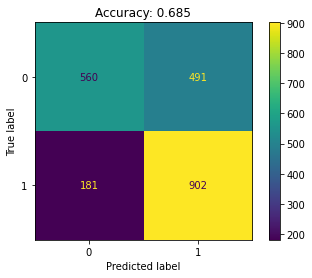

In [ ]:
test_lab = []
for i in list(n_t_d['Flames']):
  test_lab.append(int(i))
plot_cm(y=test_lab, pred=pred)

# Evaluate

In [ ]:
# tensorflow version must be the 2.6.2 and keras version must be 2.6.0.
!pip install tensorflow==2.6.2
%tensorflow_version 2.6.2

# !!!!!!!!!!!!!! AFTER EXECUTING THIS CELL, RESTART THE RUNTIME !!!!!!!!!!!!!!!!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.4/458.4 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.9/462.9 KB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 19.6 MB/s eta 0:00:00
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=38b26d5957a5b863867a7b23a69388da30bcd0c4cd01379b00505a

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.6.2


In [ ]:
from tensorflow import keras
print(keras.__version__)

2.6.0


In [ ]:
class DataGenerator(Sequence):

    def __init__(self, data, batch_size, shuffle_data, aug):
        self.num_samples = len(data)
        self.data = shuffle(data) if shuffle_data else data
        self.batch_size = batch_size
        self.aug = aug        
        self.additional_targets = {[f'image{i}' for i in range(sequence_length-1)][j]:'image' for j in range(sequence_length-1)}

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        #print('starting index: ', idx * self.batch_size)
        batch_samples = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_train = []
        y_train = []
        for batch_sample in batch_samples:
            x = batch_sample[0]   # Load image (X)
            y = batch_sample[1]   # Read label (y)
            temp_data_list = []
            for img_name in x:
                try:
                    img = cv2.imread(img_name)
                    img = cv2.resize(img, (224,224))
                    temp_data_list.append(img[:,:, ::-1])
                except Exception as e:
                    print(e)
                    print('error reading file: ', img_name)
            # if self.aug:
            #     temp_data_list = self.__totransform__(temp_data_list)
            # Add example to arrays
            X_train.append(temp_data_list)
            y_train.append(y)
        # Make sure they're numpy arrays (as opposed to lists)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        return X_train, y_train

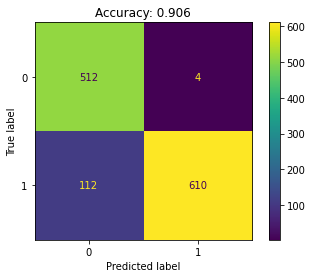

In [ ]:
import os
import cv2
import math
import copy
from collections import deque
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

def file_generator(data_path, data_files, temporal_stride, temporal_length):
  '''
  data_files - list of csv files to be read
  '''
  for f in data_files:
    tmp_df = pd.read_csv(os.path.join(data_path, f))
    total_images = len(tmp_df)
    if total_images >= temporal_length:
      num_samples = int((total_images - temporal_length)/temporal_stride) + 1
      # print('num of samples from vid seq-{}: {}'.format(f, num_samples))
    else:
      # print('num of frames is less than temporal length; hence discarding this \
      #       file-{}'.format(f))
      continue

    samples = deque()
    labels = deque()

    for index, row in tmp_df.iterrows():
      samples.append('/content/drive/My Drive' + row['filename'][30:])
      labels.append(int(row['Flames']))
      if len(samples) == temporal_length:
        to_delete = False
        if labels.count(labels[0]) != len(labels):
          to_delete = True
        samples_c = copy.deepcopy(samples)
        for t in range(temporal_stride):
          samples.popleft()
          labels.popleft()
        if to_delete: continue
        yield samples_c, labels[0]

def load_samples(CSV_folder, temporal_stride, temporal_length):
  data_path = os.path.join('csv', CSV_folder)
  data_files = os.listdir(data_path)
  file_gen = file_generator(data_path, data_files, temporal_stride, temporal_length)
  iterator = True
  data_list = []

  while iterator:
    try:
      x, y = next(file_gen)
      x = list(x)
      data_list.append([x, y])
    except Exception as e:
      # print('Exception: ', e)
      iterator = False
      # print('end of data generator ')
  return data_list

test_data = load_samples(CSV_folder='Test/urban/KFold_short-range/fold5', temporal_stride=sequence_stride,
                            temporal_length=sequence_length)

test_gen = DataGenerator(data=test_data, batch_size=batch_size, 
                         shuffle_data=False, aug=False)

model = load_model('models/urban/short-range/EfficientDet/case10/case10_best_model5.h5')

groundtruth = []
for sample in test_data:
  groundtruth.append(sample[1])

pred = model.predict(test_gen)
predictions = []
for i in range(len(pred)):
  if pred[i][0] > 0.5:
    predictions.append(1)
  else:
    predictions.append(0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(data, pred):
  y = np.array(data)
  p = np.array(pred)
  cm = confusion_matrix(y, p)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Accuracy: %.3f' % (y==p).mean())
  plt.show()
plot_cm(data=groundtruth, pred=predictions)

In [ ]:
model.evaluate(test_gen)

78/78 [==============================] - 495s 6s/step - loss: 0.2149 - accuracy: 0.9063


[0.21487870812416077, 0.9063004851341248]

In [ ]:
p = []
for i in pred:
  p.append(round(list(i)[0]))
p = np.array(p)
y = np.array(groundtruth)

groundtruth = list(y)
scores = list(p)

In [ ]:
from keras.metrics import AUC # Approximates the Area Under the Curve of the ROC curve
from sklearn.metrics import balanced_accuracy_score

b_acc = balanced_accuracy_score(y_true=y, y_pred=p)

TP=TN=FP=FN = 0

for i in range(len(groundtruth)):
    if groundtruth[i] == 1 and scores[i] == 1:
        TP = TP + 1
    elif groundtruth[i] == 0 and scores[i] == 0:
        TN = TN + 1
    elif groundtruth[i] == 0 and scores[i] == 1:
        FP = FP + 1
    elif groundtruth[i] == 1 and scores[i] == 0:
        FN = FN + 1

AR = (TP + TN)/(TP + TN + FP + FN)
Precision = TP/(TP + FP)
Recall = TP/(TP + FN)
TPR = TP/(TP + FN)
TNR = TN/(TN + FP)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
F1score = (2 * Precision * Recall)/(Precision + Recall)
Auc = AUC()
Auc.update_state(groundtruth, scores)

print("True Positives: " + str(TP) + "\nTrue Negatives: " + str(TN) + 
      "\nFalse Positives: " + str(FP) + "\nFalse Negatives: " + str(FN) +
      "\nTrue Positive rate: " + str(round(TPR, 3)) + "\nTrue negative rate: " +
      str(round(TNR, 3)) + "\nFalse Positive rate: " + str(round(FPR, 3)) +
      "\nFalse Negative rate: " + str(round(FNR, 3)) + "\nAccuracy Rate: " + 
      str(round(AR, 3)) + "\nPrecision: " + str(round(Precision, 3)) + 
      "\nRecall: " + str(round(Recall, 3)) + "\nBalanced accuracy: " + 
      str(round(b_acc, 3)) + "\nF1-Score: " + str(round(F1score, 3)) + 
      "\nArea under ROC curve: " + str(round(float(Auc.result()), 3)))

True Positives: 610
True Negatives: 512
False Positives: 4
False Negatives: 112
True Positive rate: 0.845
True negative rate: 0.992
False Positive rate: 0.008
False Negative rate: 0.155
Accuracy Rate: 0.906
Precision: 0.993
Recall: 0.845
Balanced accuracy: 0.919
F1-Score: 0.913
Area under ROC curve: 0.919


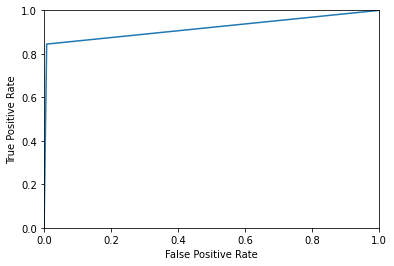

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()

p = []
for i in pred:
  p.append(round(list(i)[0]))
p = np.array(p)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true=np.array(groundtruth), y_score=p)
plot_roc_curve(fpr_keras,tpr_keras)

## Which samples are wrongly predicted?

In [ ]:
wrong_predictions01 = []

for i in range(len(groundtruth)):
    if test_data[i][1] == 0 and scores[i] == 1:
      wrong_predictions01.append(test_data[i][0])
for i in range(len(wrong_predictions01)):
  print(wrong_predictions01[i])

['/content/drive/My Drive/Tesi/datasets/urban/short-range/dunnings/frames/negative/FlashoverDemonstration.mp4/448.jpg', '/content/drive/My Drive/Tesi/datasets/urban/short-range/dunnings/frames/negative/FlashoverDemonstration.mp4/449.jpg', '/content/drive/My Drive/Tesi/datasets/urban/short-range/dunnings/frames/negative/FlashoverDemonstration.mp4/450.jpg', '/content/drive/My Drive/Tesi/datasets/urban/short-range/dunnings/frames/negative/FlashoverDemonstration.mp4/451.jpg']
['/content/drive/My Drive/Tesi/datasets/urban/short-range/dunnings/frames/negative/FlashoverDemonstration.mp4/450.jpg', '/content/drive/My Drive/Tesi/datasets/urban/short-range/dunnings/frames/negative/FlashoverDemonstration.mp4/451.jpg', '/content/drive/My Drive/Tesi/datasets/urban/short-range/dunnings/frames/negative/FlashoverDemonstration.mp4/452.jpg', '/content/drive/My Drive/Tesi/datasets/urban/short-range/dunnings/frames/negative/FlashoverDemonstration.mp4/453.jpg']
['/content/drive/My Drive/Tesi/datasets/urban/

In [ ]:
wrong_predictions10 = []

for i in range(len(groundtruth)):
    if test_data[i][1] == 1 and scores[i] == 0:
      
      wrong_predictions10.append(test_data[i][0])
for i in range(len(wrong_predictions10)):
  print(wrong_predictions10[i])

['/content/drive/My Drive/Tesi/datasets/urban/short-range/Depositphotos/frames/positive/depositphotos_162701594-stock-video-fire-billowing-inside-a-wooden.mp4/1.jpg', '/content/drive/My Drive/Tesi/datasets/urban/short-range/Depositphotos/frames/positive/depositphotos_162701594-stock-video-fire-billowing-inside-a-wooden.mp4/2.jpg', '/content/drive/My Drive/Tesi/datasets/urban/short-range/Depositphotos/frames/positive/depositphotos_162701594-stock-video-fire-billowing-inside-a-wooden.mp4/3.jpg', '/content/drive/My Drive/Tesi/datasets/urban/short-range/Depositphotos/frames/positive/depositphotos_162701594-stock-video-fire-billowing-inside-a-wooden.mp4/4.jpg']
['/content/drive/My Drive/Tesi/datasets/urban/short-range/Depositphotos/frames/positive/depositphotos_162701594-stock-video-fire-billowing-inside-a-wooden.mp4/3.jpg', '/content/drive/My Drive/Tesi/datasets/urban/short-range/Depositphotos/frames/positive/depositphotos_162701594-stock-video-fire-billowing-inside-a-wooden.mp4/4.jpg', '/

In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = test_data[0][0][0]
uno = video_name[56:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[56:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in test_data:
  video_name = list_of_lists[0][0]
  uno = video_name[56:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[56:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df = pd.DataFrame(all_videos)
df

,name,num
0,CarLights2.avi,15
1,depositphotos_103917160-stock-video-welcome-to...,11
2,depositphotos_107025046-stock-video-dry-straw-...,11
3,depositphotos_113634798-stock-video-firemen-ho...,2
4,depositphotos_133306378-stock-video-night-stre...,6
5,depositphotos_162701594-stock-video-fire-billo...,23
6,depositphotos_185245644-stock-video-fireman-us...,15
7,depositphotos_363129176-stock-video-worshipper...,14
8,depositphotos_480195420-stock-video-young-boys...,18
9,depositphotos_79133104-stock-video-an-abandone...,17


In [ ]:
for index,row in df.iterrows():
  print(row['name'])

CarLights2.avi
depositphotos_103917160-stock-video-welcome-to-vegas-sign-by.mp4
depositphotos_107025046-stock-video-dry-straw-burning-close-up.mp4
depositphotos_113634798-stock-video-firemen-hosing-down-buring-car.mp4
depositphotos_133306378-stock-video-night-street-police-cars-waiting.mp4
depositphotos_162701594-stock-video-fire-billowing-inside-a-wooden.mp4
depositphotos_185245644-stock-video-fireman-using-pike-pole-open.mp4
depositphotos_363129176-stock-video-worshippers-come-to-pashupatinath-temple.mp4
depositphotos_480195420-stock-video-young-boys-playing-swings-park.mp4
depositphotos_79133104-stock-video-an-abandoned-farmhouse-is-overgrown.mp4
negsVideo10.1072.avi
negsVideo11.1073.avi
negsVideo5.862.avi
testneg04.810.avi
testpos01.817.avi
testpos02.818.avi
car3.mp4
house6.mp4
icra.mp4
istockphoto-1034430690-640_adpp_is.mp4
istockphoto-1163568298-640_adpp_is.mp4
istockphoto-1168482079-640_adpp_is.mp4
istockphoto-1174959897-640_adpp_is.mp4
istockphoto-1184392210-640_adpp_is.mp4
ist

In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = wrong_predictions10[0][0]
uno = video_name[56:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[56:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in wrong_predictions10:
  video_name = list_of_lists[0]
  uno = video_name[56:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[56:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df_wrong10 = pd.DataFrame(all_videos)
df_wrong10

,name,num
0,depositphotos_162701594-stock-video-fire-billo...,14
1,testpos02.818.avi,8
2,house6.mp4,26
3,fire2.mp4,36
4,test1.mp4,18
5,flame2.avi,9
6,modern-warfare-soldier-in-action-near-window-c...,1


In [ ]:
for index,row in df_wrong10.iterrows():
  print(row['name'])

depositphotos_162701594-stock-video-fire-billowing-inside-a-wooden.mp4
testpos02.818.avi
house6.mp4
fire2.mp4
test1.mp4
flame2.avi
modern-warfare-soldier-in-action-near-window-changing-magazine-and-take-cover--SBV-346537349-preview.mp4


In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = wrong_predictions01[0][0]
uno = video_name[56:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[56:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in wrong_predictions01:
  video_name = list_of_lists[0]
  uno = video_name[56:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[56:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df_wrong01 = pd.DataFrame(all_videos)
df_wrong01

,name,num
0,FlashoverDemonstration.mp4,4


In [ ]:
for index,row in df_wrong01.iterrows():
  print(row['name'])

FlashoverDemonstration.mp4
